# Solução do Desafio de Tokenização e Embeddings

Este notebook resolve as questões propostas no desafio final do capítulo sobre Tokenização.

**Objetivos:**
1. Adicionar um Part Number real (`STM32F407`) e verificar sua posição semântica.
2. Adicionar a palavra `Banco` e verificar se o modelo a associa mais com `Assento` ou `Dinheiro` (polissemia).

## 1. Configuração Inicial
Carregando as bibliotecas necessárias e o modelo BERT em português.

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine

print("Carregando modelo...")
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
print("Modelo carregado!")

c:\Users\fpf\Documents\jpmarinw\semana3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Carregando modelo...
Modelo carregado!


## 2. Função de Embeddings
Extrai o vetor semântico (embedding) de uma palavra ou frase usando o modelo.

In [2]:
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling: média dos vetores de todos os tokens para representar a frase inteira
    return outputs.last_hidden_state.mean(dim=1)[0].numpy()

## 3. Preparação dos Dados
Definindo a lista de palavras, incluindo os exemplos originais e os novos termos do desafio.

In [3]:
# Lista original + novas palavras
palavras_base = [
    # Componentes
    "Resistor", "Capacitor", "Diodo", "Transistor", "Chip",
    # Ferramentas/Processos
    "Solda", "Multímetro", "Alicate", "Reflow", "Estanho",
    # Aleatórios (Controle)
    "Pizza", "Futebol", "Praia", "Música"
]

# Palavras do desafio
palavras_desafio = ["STM32F407", "Banco", "Assento", "Dinheiro"]
todas_palavras = palavras_base + palavras_desafio

print("Gerando embeddings...")
vetores = []
for p in todas_palavras:
    vetores.append(get_embedding(p))

vetores = np.array(vetores)
print(f"Total de vetores gerados: {len(vetores)}")

Gerando embeddings...
Total de vetores gerados: 18


## 4. Visualização 2D (PCA)
Reduzindo a dimensionalidade para 2D para visualizarmos como o modelo agrupa essas palavras.

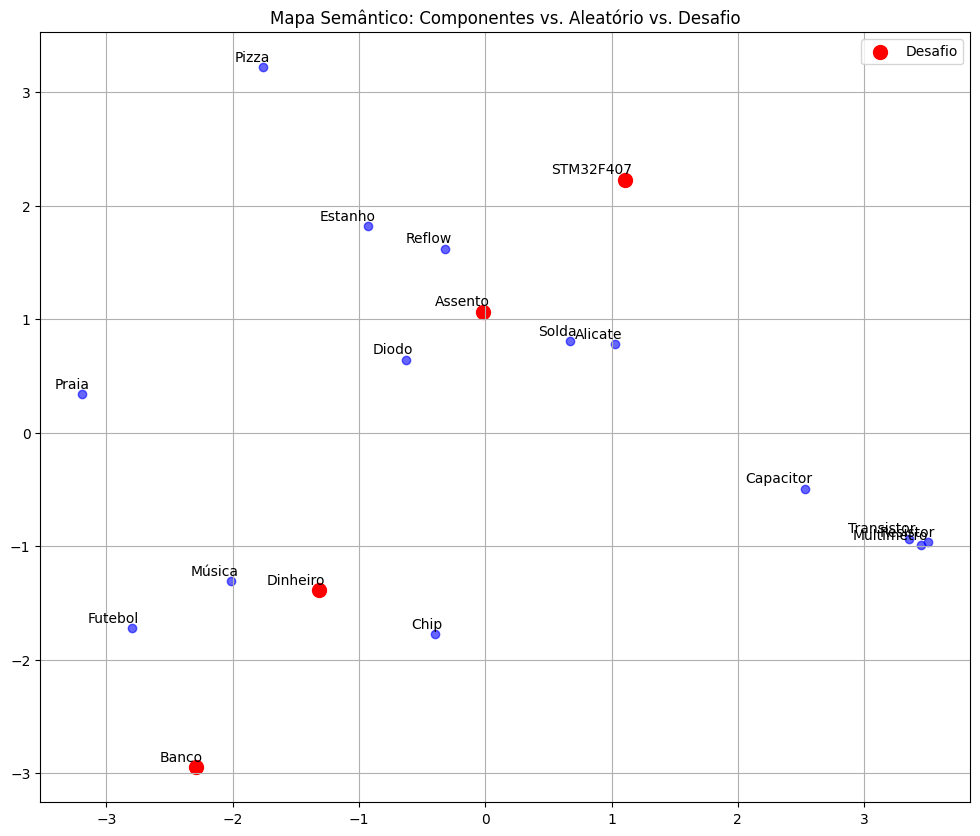

In [4]:
# PCA para 2D
pca = PCA(n_components=2)
vetores_2d = pca.fit_transform(vetores)

# Plotar
plt.figure(figsize=(12, 10))

# Pontos normais em azul
plt.scatter(vetores_2d[:, 0], vetores_2d[:, 1], c='blue', alpha=0.6)

# Destacar os pontos do desafio em vermelho
indices_desafio = [todas_palavras.index(p) for p in palavras_desafio]
plt.scatter(vetores_2d[indices_desafio, 0], vetores_2d[indices_desafio, 1], c='red', s=100, label='Desafio')

# Adicionar rótulos
for i, palavra in enumerate(todas_palavras):
    plt.annotate(palavra, xy=(vetores_2d[i, 0], vetores_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.title("Mapa Semântico: Componentes vs. Aleatório vs. Desafio")
plt.grid(True)
plt.legend()
plt.show()

## 5. Análise Numérica e Respostas
Vamos calcular a similaridade de cosseno para dar respostas precisas.

In [5]:
def calc_sim(v1, v2):
    return 1 - cosine(v1, v2)

print("--- Resultados do Desafio ---")

# --- Questão 1: Part Number Real ---
idx_stm = todas_palavras.index("STM32F407")
vec_stm = vetores[idx_stm]

# Centróide dos componentes para comparação
indices_comp = [todas_palavras.index(p) for p in ["Resistor", "Capacitor", "Diodo", "Transistor", "Chip"]]
centroide_comp = np.mean(vetores[indices_comp], axis=0)
sim_stm_comp = calc_sim(vec_stm, centroide_comp)

# Centróide dos aleatórios
indices_rand = [todas_palavras.index(p) for p in ["Pizza", "Futebol", "Praia", "Música"]]
centroide_rand = np.mean(vetores[indices_rand], axis=0)
sim_stm_rand = calc_sim(vec_stm, centroide_rand)

print(f"\n1. Análise do 'STM32F407':")
print(f"   Similaridade com grupo Componentes: {sim_stm_comp:.4f}")
print(f"   Similaridade com grupo Aleatório:   {sim_stm_rand:.4f}")
if sim_stm_comp > sim_stm_rand:
    print("   >> Conclusão: Caiu mais perto dos Componentes (o modelo captou o padrão técnico).")
else:
    print("   >> Conclusão: Caiu isolado.")

# --- Questão 2: A Palavra 'Banco' ---
idx_banco = todas_palavras.index("Banco")
idx_assento = todas_palavras.index("Assento")
idx_dinheiro = todas_palavras.index("Dinheiro")

sim_banco_assento = calc_sim(vetores[idx_banco], vetores[idx_assento])
sim_banco_dinheiro = calc_sim(vetores[idx_banco], vetores[idx_dinheiro])

print(f"\n2. Análise da palavra 'Banco':")
print(f"   Similaridade com 'Assento':  {sim_banco_assento:.4f}")
print(f"   Similaridade com 'Dinheiro': {sim_banco_dinheiro:.4f}")
if sim_banco_assento > sim_banco_dinheiro:
    print("   >> O modelo associou 'Banco' primariamente a objeto/móvel.")
else:
    print("   >> O modelo associou 'Banco' primariamente a instituição financeira.")

print("\n3. Contexto:")
print("   O resultado acima reflete o viés do corpus de treino. Em uma frase completa, o Embedding Contextual se adaptaria.")

--- Resultados do Desafio ---

1. Análise do 'STM32F407':
   Similaridade com grupo Componentes: 0.5277
   Similaridade com grupo Aleatório:   0.4663
   >> Conclusão: Caiu mais perto dos Componentes (o modelo captou o padrão técnico).

2. Análise da palavra 'Banco':
   Similaridade com 'Assento':  0.5991
   Similaridade com 'Dinheiro': 0.7000
   >> O modelo associou 'Banco' primariamente a instituição financeira.

3. Contexto:
   O resultado acima reflete o viés do corpus de treino. Em uma frase completa, o Embedding Contextual se adaptaria.
